# Markowitz Portfolio's Theory #

### Building the Efficient Frontier ###

In [2]:
# Import Libraries

# Data Management
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt

# Optiminization
from scipy.optimize import minimize

# Pretty Notation
from IPython.display import display, Math

In [7]:
def import_financial_data(
    ticker: str
):

    # Check the ticker for Upper Cases
    ticker = ticker if ticker.isupper() else ticker.upper()

    # Import data
    df = pd.read_csv(rf"..\stocks\{ticker}.csv")

    # Set the Index
    df = df.set_index('Date')
    df.index = pd.to_datetime(df.index)

    df_useful_data = df[['Open Price', 'High Price', 'Low Price', 'Close Price']]

    df_useful_data = df_useful_data.rename(columns={
        "Open Price":"Open",
        "High Price":"High",
        "Low Price":"Low",
        "Close Price":"Close",
    })

    # Drop NaN's
    df_useful_data.dropna(inplace = True)

    return df_useful_data.loc["2023-01-01":]

In [8]:
# Import Data

# Apple Data
df_1 = import_financial_data("AAPL")

# Amazon Data
df_2 =  import_financial_data("AMZN")

# Meta Data
df_3 =  import_financial_data("META")

# Microsoft Data
df_4 =  import_financial_data("MSFT")

In [9]:
# Create the joint dataframe

df_data = pd.DataFrame()

df_data['AAPL'] = df_1['Close']
df_data['AMZN'] = df_2['Close']
df_data['META'] = df_3['Close']
df_data['MSFT'] = df_4['Close']

df_data = df_data.dropna()

df_returns = df_data.pct_change(1).mul(100)
df_returns = df_returns.apply(lambda x: x.fillna(x.mean()), axis=0)

df_returns

,AAPL,AMZN,META,MSFT
Date,,,,
2023-01-03,0.145976,0.190511,0.364881,0.136387
2023-01-04,1.031422,-0.792356,2.108385,-4.374322
2023-01-05,-1.060462,-2.372563,-0.337599,-2.963771
2023-01-06,3.679411,3.561116,2.426343,1.178534
2023-01-09,0.408888,1.486989,-0.423012,0.973636
...,...,...,...,...
2024-10-22,-0.262179,0.333210,1.190973,2.084627
2024-10-23,-2.162300,-2.630469,-3.147712,-0.680686
2024-10-24,-0.082337,0.904120,0.725576,0.030617


In [10]:
# Theoretically we could use the average as the expected returns (these are daily returns)
expected_returns = df_returns.mean()

expected_returns

AAPL    0.145976
AMZN    0.190511
META    0.364881
MSFT    0.136387
dtype: float64

In [11]:
# The volatility is calculated with the standard deviations (also daily volatilities)

volat = df_returns.dropna().std()

volat

AAPL    1.371158
AMZN    1.915547
META    2.454451
MSFT    1.420584
dtype: float64

In [12]:
# Covariance Matrix

cov_matrix = df_returns.dropna().cov()

cov_matrix

,AAPL,AMZN,META,MSFT
AAPL,1.880075,1.035668,1.264652,0.975283
AMZN,1.035668,3.669319,2.734260,1.651641
META,1.264652,2.734260,6.024327,1.892687
MSFT,0.975283,1.651641,1.892687,2.018058


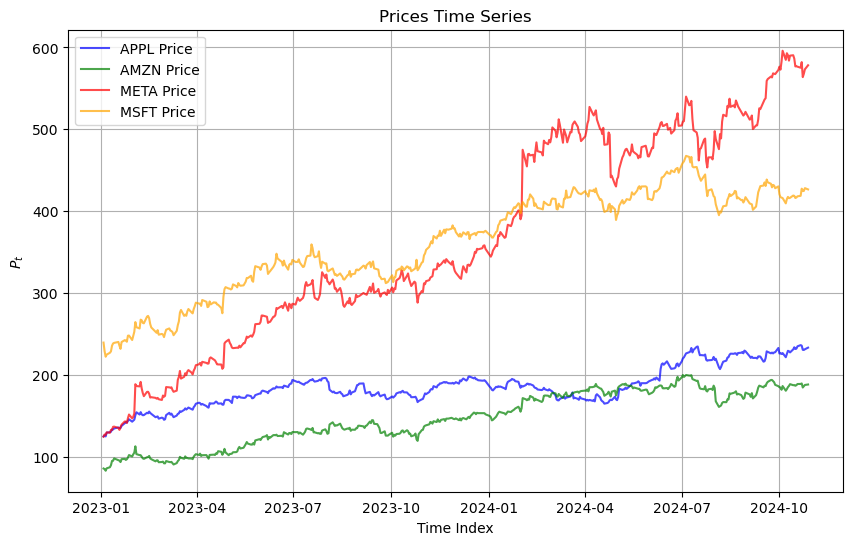

In [13]:
# Time Series Graphs
plt.figure(figsize=(10, 6))
plt.plot(df_data['AAPL'], label='APPL Price', color='blue', alpha=0.7)
plt.plot(df_data['AMZN'], label='AMZN Price', color='green', alpha=0.7)
plt.plot(df_data['META'], label='META Price', color='red', alpha=0.7)
plt.plot(df_data['MSFT'], label='MSFT Price', color='orange', alpha=0.7)

# Config
plt.title('Prices Time Series')
plt.xlabel('Time Index')
plt.ylabel('$P_t$')
plt.legend()

# Show
plt.grid(True)
plt.show()

In [14]:
# The Markowitz's Theory stablish that a portfolio's returns and variance are defined by the following equations

display(Math(r"\mu_{P} = \sum_{i=1}^{n}{\omega_i\mu_i}"))
display(Math(r"\sigma_P^2=\sum_{i=1}^{n}\sum_{j=1}^n{\omega_i\omega_j\gamma_ij}"))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [15]:
# To create random portfolios first we need to create random weights

def rand_weights(n):
    ''' Produces n random weights that sum to 1 '''
    k = np.random.rand(n)
    return k / sum(k)

print(rand_weights(4))

[0.33817697 0.34071084 0.07670889 0.2444033 ]


In [16]:
### This function create a random portfolio based on random weights

def random_portfolio(returns, cov_matrix):
    ''' 
    Returns the mean and standard deviation of returns for a random portfolio
    '''
    # Generate Random Weights
    weights = rand_weights(len(returns))
    
    # Calculate the Portfolio's Returns
    mean_return = np.dot(weights, returns)
    
    # Calculate the Portfolio's Risk
    portfolio_variance = np.dot(weights.T, np.dot(cov_matrix, weights))
    portfolio_stddev = np.sqrt(portfolio_variance)
    
    return mean_return, portfolio_stddev

returns_i, risk_i = random_portfolio(expected_returns, cov_matrix)

print(f"The Portfolio's Return is: {returns_i.round(3)}")
print(f"The Portfolio's Volatility is: {risk_i.round(3)}")

The Portfolio's Return is: 0.178
The Portfolio's Volatility is: 1.344


In [17]:
# We can use this function to generate several random portfolios

def generate_random_portfolios(n_portfolios, expected_returns, cov_matrix):

    # Lists to store the portfolios' information
    means = []
    stds = []

    # Generate the protfolios
    for _ in range(n_portfolios):
        mean, std = random_portfolio(expected_returns.values.flatten(), cov_matrix)
        means.append(mean)
        stds.append(std)
    
    # Store them in a DataFrame
    portfolios = pd.DataFrame({
        'Mean Return': means,
        'Std Dev': stds
    })
    
    return portfolios

n_portfolios = 700
portfolios = generate_random_portfolios(n_portfolios, expected_returns, cov_matrix)

print(portfolios)

     Mean Return   Std Dev
0       0.210846  1.402805
1       0.214784  1.439240
2       0.193901  1.388636
3       0.224832  1.458108
4       0.233788  1.491501
..           ...       ...
695     0.182255  1.331148
696     0.206913  1.447143
697     0.207150  1.433929
698     0.209000  1.515953
699     0.182223  1.336394

[700 rows x 2 columns]


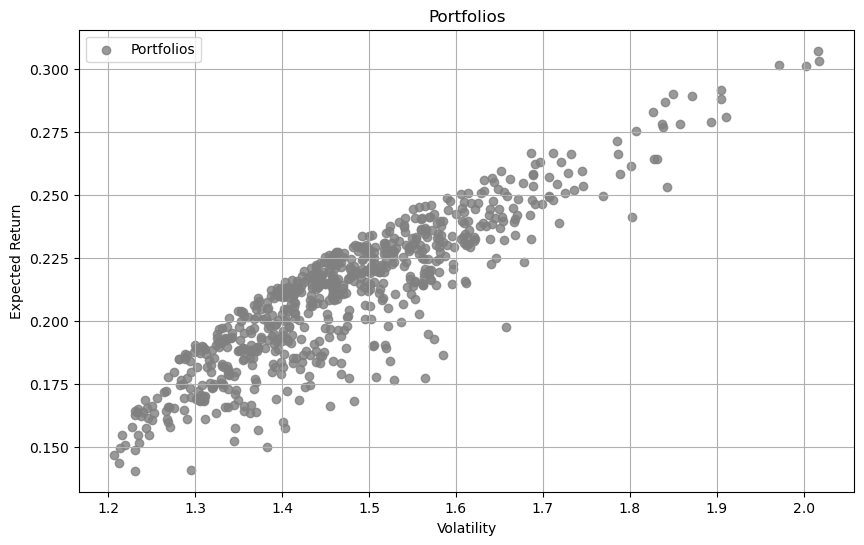

In [18]:
# Portfolios Plot
plt.figure(figsize=(10, 6))
plt.scatter(portfolios['Std Dev'], portfolios['Mean Return'], color='gray', alpha=0.8, label='Portfolios')

# Config
plt.title('Portfolios')
plt.xlabel('Volatility')
plt.ylabel('Expected Return')
plt.legend()

# Show
plt.grid(True)
plt.show()

In [19]:
# We can create the Equal-Weighted Portfolio to compare it with the other portfolios
def equal_weighted_portfolio(returns, cov_matrix):
    
    # Generate the Equal Weights
    n = len(expected_returns)
    weights = np.ones(n) / n  

    # Calculate the Portfolio's Retuns
    portfolio_return = np.dot(weights, expected_returns)
    
    # Calculate the Portfolio's Risk
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    
    return portfolio_return, portfolio_volatility

returns_e, risk_e = equal_weighted_portfolio(expected_returns, cov_matrix)

print(f"The Equal-Weighted Portfolio's Return is: {returns_e.round(3)}")
print(f"The Equal-Weighted Portfolio's Volatility is: {risk_e.round(3)}")

The Equal-Weighted Portfolio's Return is: 0.209
The Equal-Weighted Portfolio's Volatility is: 1.43


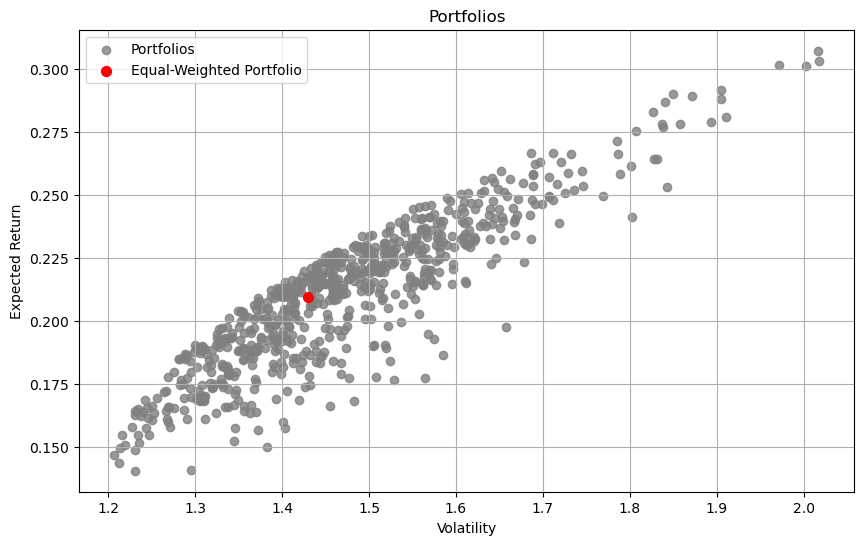

In [20]:
# Portfolios Plot
plt.figure(figsize=(10, 6))
plt.scatter(portfolios['Std Dev'], portfolios['Mean Return'], color='gray', alpha=0.8, label='Portfolios')
plt.scatter(risk_e, returns_e, color='red', s=50, label='Equal-Weighted Portfolio')  


# Config
plt.title('Portfolios')
plt.xlabel('Volatility')
plt.ylabel('Expected Return')
plt.legend()

# Show
plt.grid(True)
plt.show()

In [21]:
# Now how can we obtain the Efficient Frontier

# Optimization functions
def portfolio_performance(weights, mean_returns, cov_matrix):
    # Portfolio's Returns
    portfolio_return = np.dot(weights, mean_returns)

    #Portfolio's Volatility
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    
    return portfolio_return, portfolio_volatility
    
# Minimizing Portfolio
def minimize_volatility(weights, mean_returns, cov_matrix):
    return portfolio_performance(weights, mean_returns, cov_matrix)[1]

# Function that generates the portfolios that are located in the Efficient Frontier
def get_efficient_frontier(mean_returns, cov_matrix, num_portfolios=100):
    results = np.zeros((2, num_portfolios))
    target_returns = np.linspace(mean_returns.min(), mean_returns.max(), num_portfolios)
    
    for i, target in enumerate(target_returns):
        constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1},
                       {'type': 'eq', 'fun': lambda x: np.dot(x, mean_returns) - target})
        bounds = tuple((0, 1) for _ in range(len(mean_returns)))
        initial_guess = len(mean_returns) * [1. / len(mean_returns)]
        
        opt = minimize(minimize_volatility, initial_guess, args=(mean_returns, cov_matrix),
                       method='SLSQP', bounds=bounds, constraints=constraints)
        
        if opt.success:
            results[0, i] = target
            results[1, i] = opt.fun

    return results

efficient_frontier = get_efficient_frontier(expected_returns, cov_matrix)

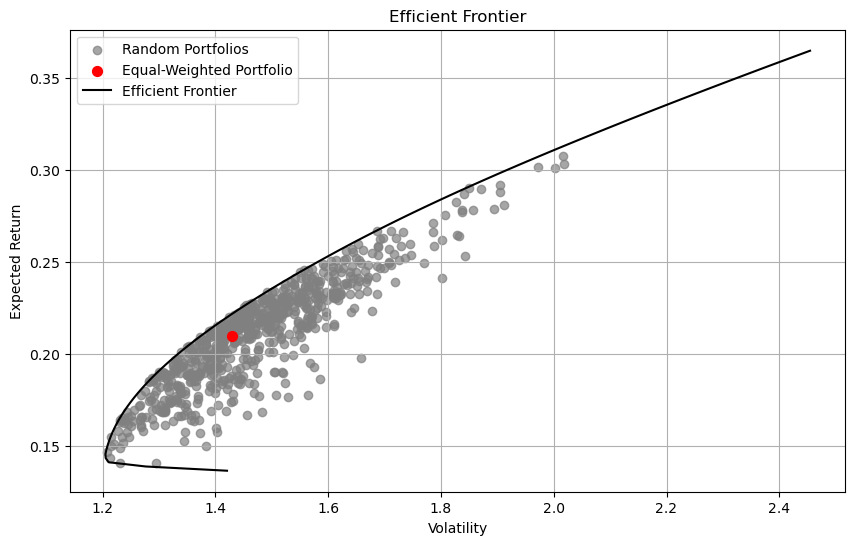

In [22]:
# Portfolios Plot
plt.figure(figsize=(10, 6))
plt.scatter(portfolios['Std Dev'], portfolios['Mean Return'], color='gray', alpha=0.7, label='Random Portfolios')
plt.scatter(risk_e, returns_e, color='red', s=50, label='Equal-Weighted Portfolio')  
plt.plot(efficient_frontier[1, :], efficient_frontier[0, :], label='Efficient Frontier', color='black')


# Config
plt.title('Efficient Frontier')
plt.xlabel('Volatility')
plt.ylabel('Expected Return')
plt.legend()

# Show
plt.grid(True)
plt.show()

In [23]:
# To find the equation of the efficient frontier we have to solve the optimization problem

display(Math(r"\sigma_P^2 = \pi_0 + \pi_1\mu_P + \pi_2\mu_P^2"))

<IPython.core.display.Math object>

In [24]:
# In the Chapter 3 of Book you can find the next forms

display(Math(r"A = \mu^⊤\Sigma^{-1}\mu"))
display(Math(r"B = \mu^⊤\Sigma^{-1}\iota"))
display(Math(r"C = \iota^⊤\Sigma^{-1}\iota"))
display(Math(r"D = AC-B^2"))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [25]:
# So let us obtain the components

mu = expected_returns.values.flatten().reshape(-1, 1)
Sigma = cov_matrix.values
Sigma_inv = np.linalg.inv(Sigma)
iota = np.ones((4, 1))

In [26]:
# And now obtain the coefficients of the Efficient Frontier

A = np.dot(np.dot(mu.T, Sigma_inv), mu)
B = np.dot(np.dot(iota.T, Sigma_inv), mu)
C = np.dot(np.dot(iota.T, Sigma_inv), iota)
D = (A*C - B*B)

print(f"This is A: {A}")
print(f"This is B: {B}")
print(f"This is C: {C}")
print(f"This is D: {D}")

This is A: [[0.02511156]]
This is B: [[0.0938747]]
This is C: [[0.69251475]]
This is D: [[0.00857766]]


In [27]:
# Then the equation

pi_0 = A/D
pi_1 = 2*B/D
pi_2 = C/D

print(f"This is the first coefficient: {pi_0}")
print(f"This is the second coefficient: {pi_1}")
print(f"This is the third coefficient: {pi_2}")

This is the first coefficient: [[2.92755182]]
This is the second coefficient: [[21.88817348]]
This is the third coefficient: [[80.73465776]]


In [28]:
# Now let us obtain the values of the efficient frontier

def equation(mu_P):
    return np.sqrt((pi_0 - pi_1 * mu_P + pi_2 * mu_P**2))

# Crear un rango de valores para mu_P
mu_P_values = np.linspace(0.09, 0.35, 400)

# Evaluar la ecuación en los valores de mu_P
sigma_P_values = equation(mu_P_values).reshape(-1, 1)

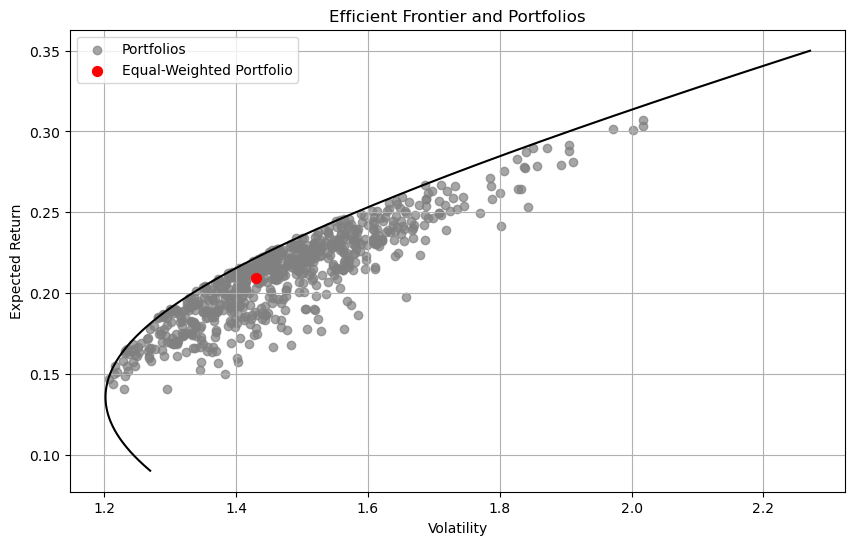

In [29]:
# Create Plot
plt.figure(figsize=(10, 6))
plt.scatter(portfolios['Std Dev'], portfolios['Mean Return'], color='grey', alpha=0.7, label='Portfolios')
plt.scatter(risk_e, returns_e, color='red', s=50, label='Equal-Weighted Portfolio') 
plt.plot(sigma_P_values, mu_P_values, color='black')


# Config
plt.title('Efficient Frontier and Portfolios')
plt.xlabel('Volatility')
plt.ylabel('Expected Return')
plt.legend()

# Show
plt.grid(True)
plt.show()


In [30]:
# Let us check if this equation is indeed correct; for the equal-weighted portfolio's volatility

risk_e_optimal = equation(returns_e)[0][0]

print(f"The Equal-Weighted Portfolio's Returns: {returns_e}")
print(f"The Equal-Weighted Portfolio's Volatility: {risk_e}")
print(f"The Optimal Volatility: {risk_e_optimal}")

The Equal-Weighted Portfolio's Returns: 0.20943873290031256
The Equal-Weighted Portfolio's Volatility: 1.4296013674792907
The Optimal Volatility: 1.3728483457370315


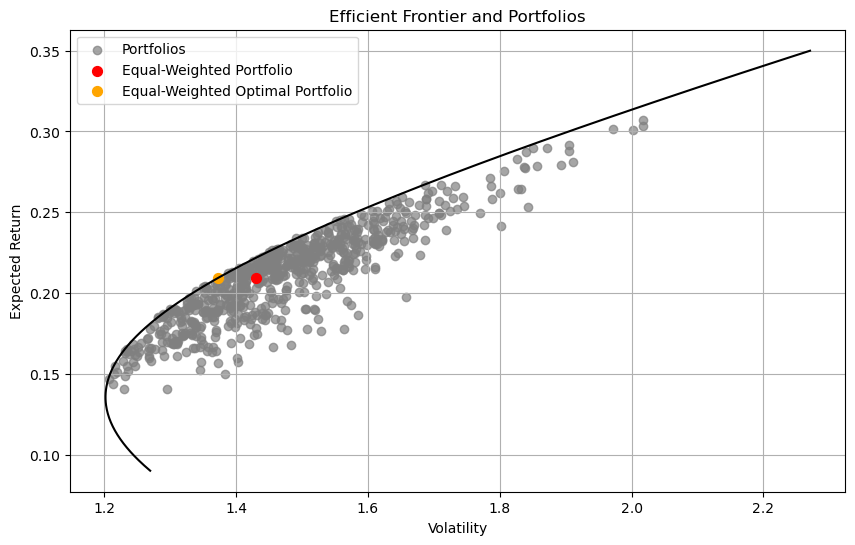

In [31]:
# Create Plot
plt.figure(figsize=(10, 6))
plt.scatter(portfolios['Std Dev'], portfolios['Mean Return'], color='grey', alpha=0.7, label='Portfolios')
plt.scatter(risk_e, returns_e, color='red', s=50, label='Equal-Weighted Portfolio')  
plt.plot(sigma_P_values, mu_P_values, color='black')
plt.scatter(risk_e_optimal, returns_e, color='orange', s=50, label='Equal-Weighted Optimal Portfolio') 

# Config
plt.title('Efficient Frontier and Portfolios')
plt.xlabel('Volatility')
plt.ylabel('Expected Return')
plt.legend()

# Show
plt.grid(True)
plt.show()


In [32]:
# Finally we just have to find the Minimum Variance Portfolio

display(Math(r"\mu_{P_{min}} = \frac{\pi_1}{2\pi_2}"))
display(Math(r"\sigma_{P_{min}}^2 = \pi_0 - \frac{\pi_1^2}{4\pi_2}"))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [33]:
# Obtain the MVP

min_returns = pi_1/(2*pi_2)
min_volat = np.sqrt(pi_0 - ((pi_1**2)/(4*pi_2)))

print(f"The MVP Returns are: {min_returns}")
print(f"The MVP Volatility is: {min_volat}")

The MVP Returns are: [[0.13555624]]
The MVP Volatility is: [[1.20167073]]


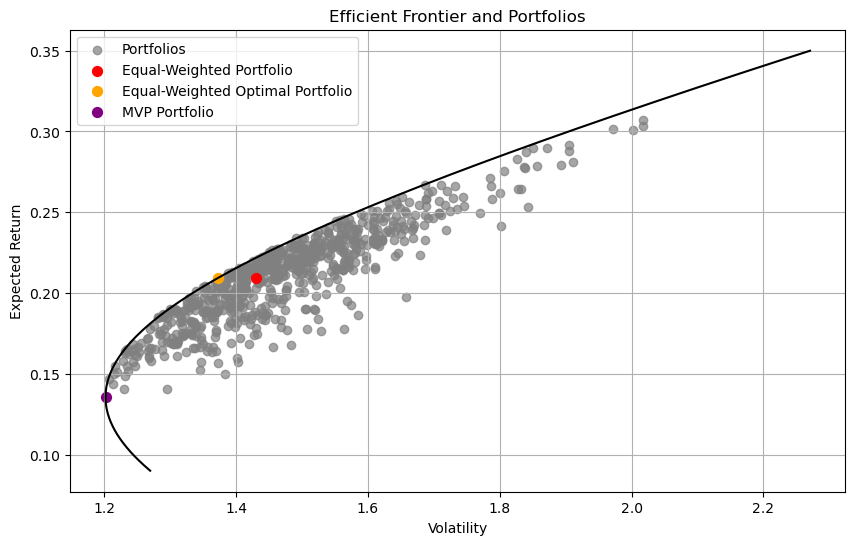

In [34]:
# Create Plot
plt.figure(figsize=(10, 6))
plt.scatter(portfolios['Std Dev'], portfolios['Mean Return'], color='grey', alpha=0.7, label='Portfolios')
plt.scatter(risk_e, returns_e, color='red', s=50, label='Equal-Weighted Portfolio')  
plt.plot(sigma_P_values, mu_P_values, color='black')
plt.scatter(risk_e_optimal, returns_e, color='orange', s=50, label='Equal-Weighted Optimal Portfolio') 
plt.scatter(min_volat, min_returns, color='purple', s=50, label='MVP Portfolio') 

# Config
plt.title('Efficient Frontier and Portfolios')
plt.xlabel('Volatility')
plt.ylabel('Expected Return')
plt.legend()

# Show
plt.grid(True)
plt.show()